In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import os

In [3]:
dataset_dir = 'D:\\Eye\\Eye Research\\Dataset Collected\\CCN'

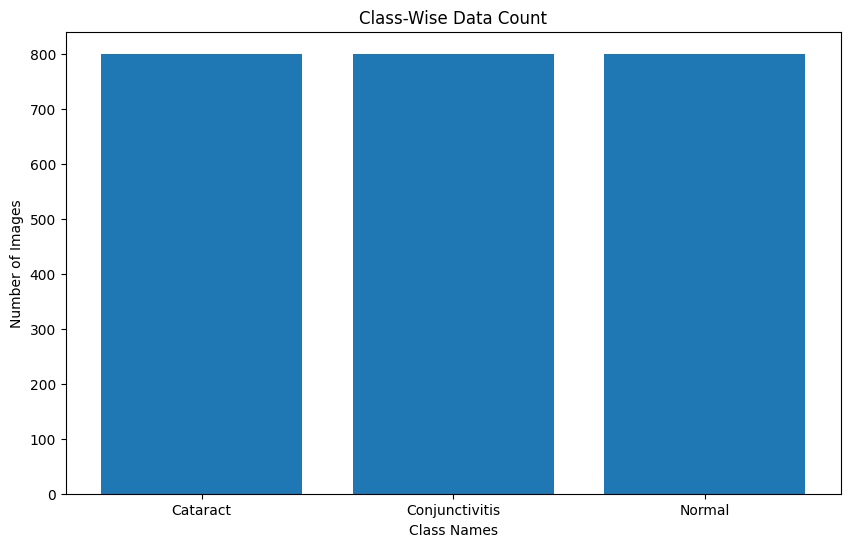

In [4]:
class_counts = {}
for subdir, dirs, files in os.walk(dataset_dir):
    for dir in dirs:
        class_counts[dir] = len(os.listdir(os.path.join(subdir, dir)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class-Wise Data Count')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


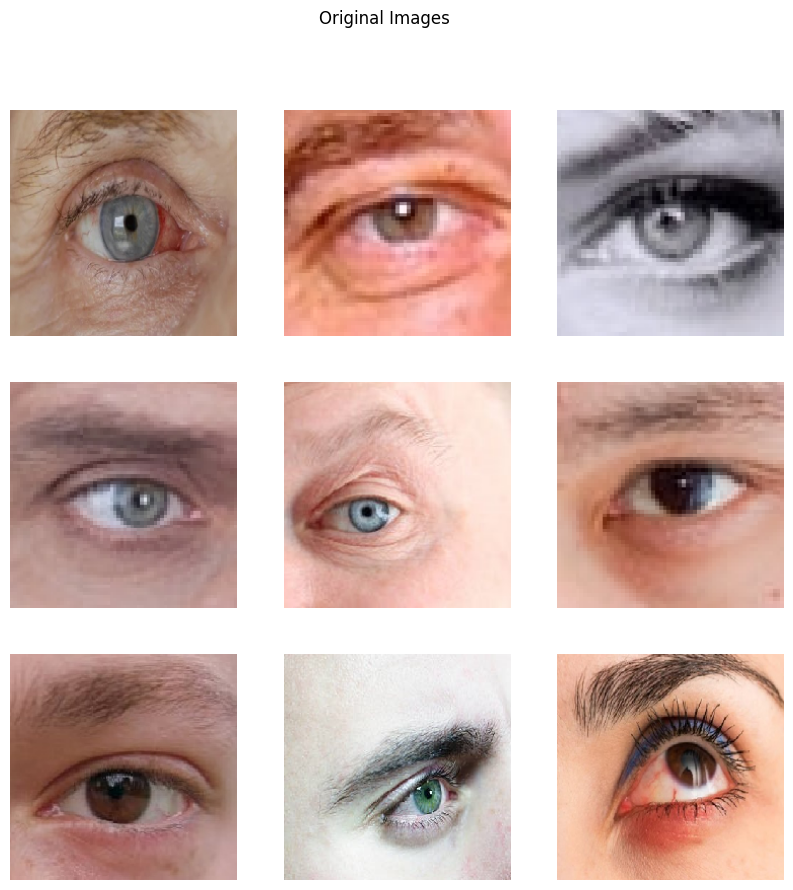

Found 2400 images belonging to 3 classes.


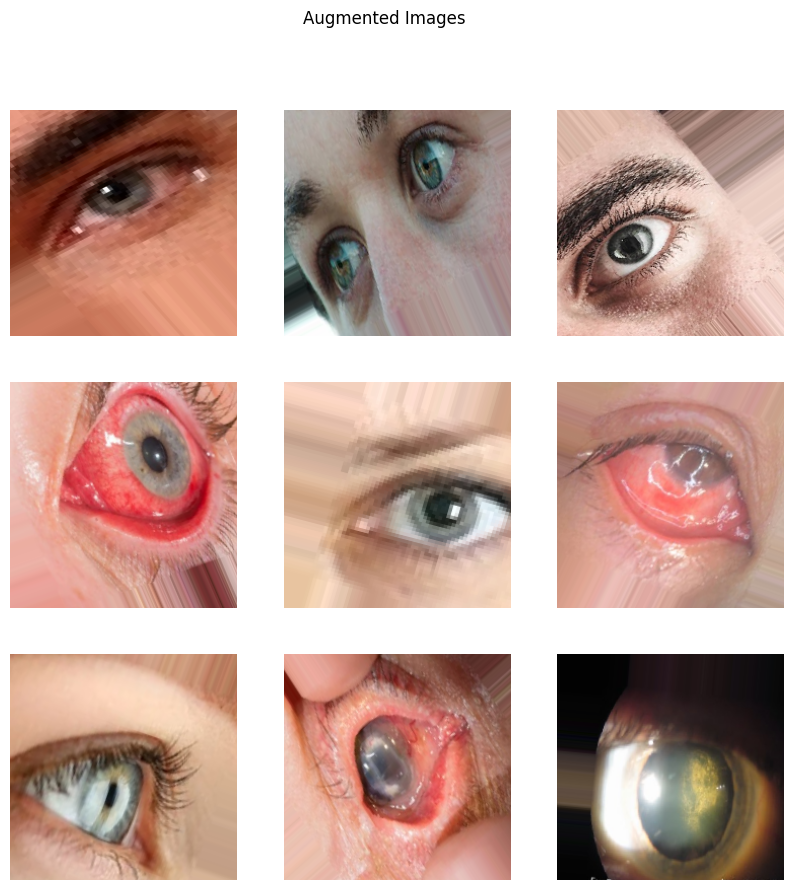

In [6]:
def plot_images(generator, title):
    sample_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_generator, "Original Images")
plot_images(augmented_datagen.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', subset='training'), "Augmented Images")

In [7]:
def create_hybrid_model(input_shape=(224, 224, 3), num_classes=len(class_counts)):
    input_tensor = Input(shape=input_shape)

    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in mobilenet_base.layers:
        layer.trainable = False
    mobilenet_features = Flatten()(mobilenet_base.output)
    mobilenet_features = Dense(256, activation='relu')(mobilenet_features)
    mobilenet_features = BatchNormalization()(mobilenet_features)
    mobilenet_features = Dropout(0.5)(mobilenet_features)

    vgg19_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in vgg19_base.layers:
        layer.trainable = False
    vgg19_features = Flatten()(vgg19_base.output)
    vgg19_features = Dense(256, activation='relu')(vgg19_features)
    vgg19_features = BatchNormalization()(vgg19_features)
    vgg19_features = Dropout(0.5)(vgg19_features)

    combined_features = Concatenate()([mobilenet_features, vgg19_features])
    x = Dense(512, activation='relu')(combined_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
def generator_to_numpy(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

X, y = generator_to_numpy(train_generator)

In [9]:
def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    return TPR, TNR, FPR, FNR

Training fold 1...


C:\Users\User\AppData\Local\Temp\ipykernel_10532\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1684s 36s/step - accuracy: 0.5814 - loss: 1.1918 - val_accuracy: 0.9167 - val_loss: 0.2098
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1444s 30s/step - accuracy: 0.8249 - loss: 0.4351 - val_accuracy: 0.9505 - val_loss: 0.1314
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 460s 8s/step - accuracy: 0.8789 - loss: 0.3436 - val_accuracy: 0.9766 - val_loss: 0.0782
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 866s 18s/step - accuracy: 0.9103 - loss: 0.2529 - val_accuracy: 0.9740 - val_loss: 0.0700
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2292s 47s/step - accuracy: 0.9543 - loss: 0.1207 - val_accuracy: 0.9714 - val_loss: 0.0619
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step - accuracy: 0.9573 - loss: 0.1105 - val_accuracy: 0.9844 - val_loss: 0.0414
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 317s 7s/step - accuracy: 0.9566 - loss: 0.1285 - val_accuracy: 0.9896 - val_loss: 0.0356
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 318s 7s/step - accuracy: 0.9732 - loss: 0.0848 - val_accuracy: 0.9

C:\Users\User\AppData\Local\Temp\ipykernel_10532\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - accuracy: 0.5669 - loss: 1.1733 - val_accuracy: 0.7578 - val_loss: 0.5546
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.8407 - loss: 0.4234 - val_accuracy: 0.9401 - val_loss: 0.1810
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - accuracy: 0.9069 - loss: 0.2341 - val_accuracy: 0.9505 - val_loss: 0.1283
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9248 - loss: 0.1919 - val_accuracy: 0.9661 - val_loss: 0.1106
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - accuracy: 0.9517 - loss: 0.1606 - val_accuracy: 0.9714 - val_loss: 0.0826
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9479 - loss: 0.1407 - val_accuracy: 0.9688 - val_loss: 0.0948
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9515 - loss: 0.1285 - val_accuracy: 0.9714 - val_loss: 0.0814
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9713 - loss: 0.0954 - val_accuracy: 0.9714 - v

C:\Users\User\AppData\Local\Temp\ipykernel_10532\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - accuracy: 0.5736 - loss: 1.2122 - val_accuracy: 0.9141 - val_loss: 0.2618
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.8501 - loss: 0.4078 - val_accuracy: 0.9531 - val_loss: 0.1632
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9094 - loss: 0.2664 - val_accuracy: 0.9583 - val_loss: 0.1305
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.9210 - loss: 0.2040 - val_accuracy: 0.9714 - val_loss: 0.1004
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.9445 - loss: 0.1481 - val_accuracy: 0.9714 - val_loss: 0.1008
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9471 - loss: 0.1413 - val_accuracy: 0.9714 - val_loss: 0.0949
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - accuracy: 0.9712 - loss: 0.0891 - val_accuracy: 0.9688 - val_loss: 0.0964
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.9739 - loss: 0.0818 - val_accuracy: 0.9766 - v

C:\Users\User\AppData\Local\Temp\ipykernel_10532\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - accuracy: 0.5808 - loss: 1.1277 - val_accuracy: 0.8776 - val_loss: 0.3379
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.8548 - loss: 0.4430 - val_accuracy: 0.9323 - val_loss: 0.2015
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 360s 8s/step - accuracy: 0.8971 - loss: 0.2628 - val_accuracy: 0.9453 - val_loss: 0.1612
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 364s 8s/step - accuracy: 0.9138 - loss: 0.2284 - val_accuracy: 0.9557 - val_loss: 0.1142
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.9327 - loss: 0.1884 - val_accuracy: 0.9609 - val_loss: 0.1093
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - accuracy: 0.9598 - loss: 0.0987 - val_accuracy: 0.9661 - val_loss: 0.0953
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - accuracy: 0.9757 - loss: 0.0765 - val_accuracy: 0.9661 - val_loss: 0.0917
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.9716 - loss: 0.0846 - val_accuracy: 0.9714 - v

C:\Users\User\AppData\Local\Temp\ipykernel_10532\872696981.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 372s 8s/step - accuracy: 0.5845 - loss: 1.1085 - val_accuracy: 0.9062 - val_loss: 0.2862
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - accuracy: 0.8502 - loss: 0.4006 - val_accuracy: 0.9349 - val_loss: 0.1760
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9106 - loss: 0.2641 - val_accuracy: 0.9401 - val_loss: 0.1359
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9345 - loss: 0.1810 - val_accuracy: 0.9661 - val_loss: 0.0979
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9460 - loss: 0.1425 - val_accuracy: 0.9766 - val_loss: 0.0780
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9545 - loss: 0.1325 - val_accuracy: 0.9688 - val_loss: 0.0929
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9688 - loss: 0.0769 - val_accuracy: 0.9844 - val_loss: 0.0555
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9855 - loss: 0.0448 - val_accuracy: 0.9792 - v

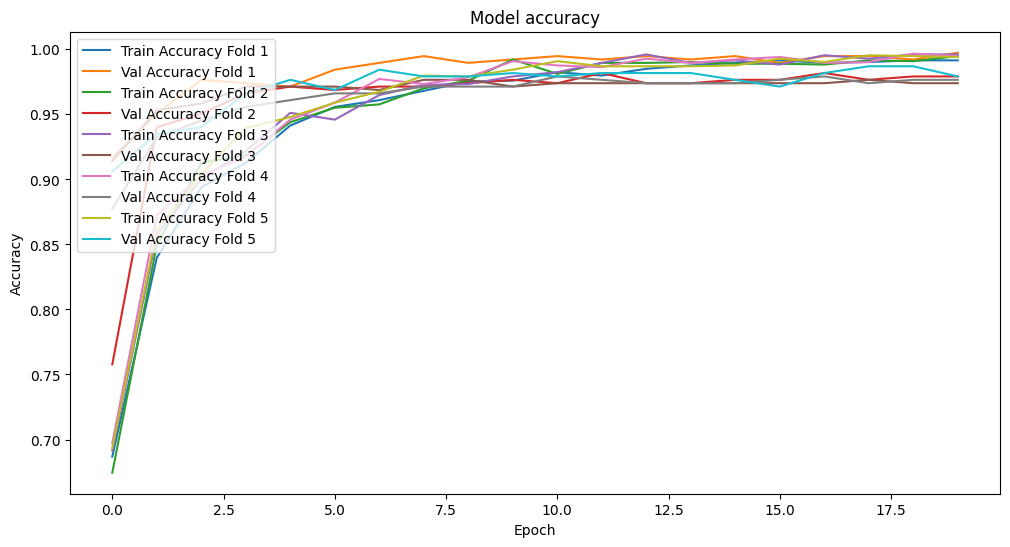

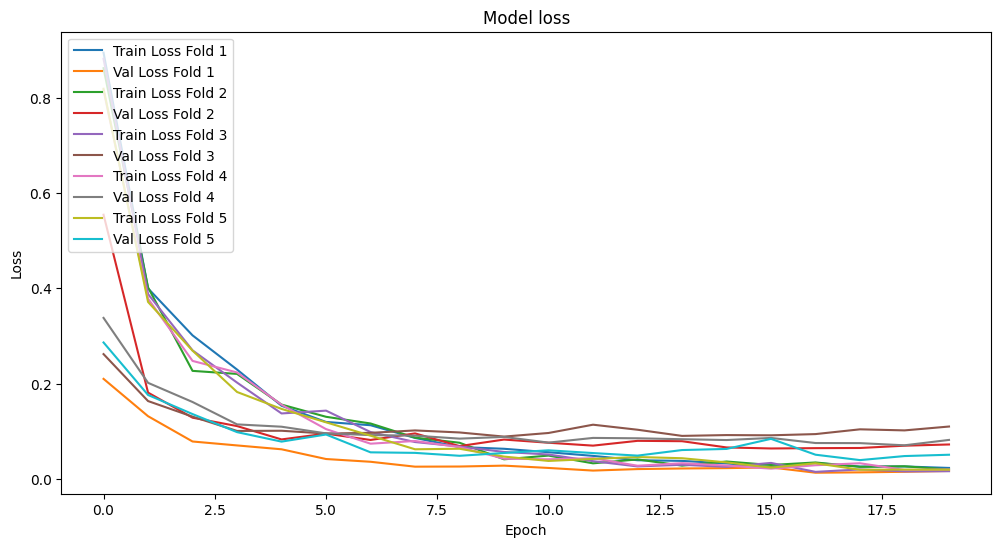

Average Validation Accuracy: 0.98125
Validation Accuracies for each fold: [0.9973958134651184, 0.9791666865348816, 0.9739583134651184, 0.9765625, 0.9791666865348816]
Average TPR: [0.99368308 0.97830125 0.97082449]
Average TNR: [0.98344646 0.99288968 0.99531761]
Average FPR: [0.01655354 0.00711032 0.00468239]
Average FNR: [0.00631692 0.02169875 0.02917551]
Found 2400 images belonging to 3 classes.
75/75 - 423s - 6s/step - accuracy: 0.9921 - loss: 0.0318
75/75 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step
Test Data Classification Report:
                precision    recall  f1-score   support

      Cataract       0.98      1.00      0.99       800
Conjunctivitis       1.00      0.98      0.99       800
        Normal       1.00      0.99      0.99       800

      accuracy                           0.99      2400
     macro avg       0.99      0.99      0.99      2400
  weighted avg       0.99      0.99      0.99      2400

Test Data Confusion Matrix:
[[800   0   0]
 [  9 788   3]
 [  6   1 793]]


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
histories = []
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = create_hybrid_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    histories.append(history)
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
    class_report = classification_report(y_val, y_val_pred_classes, target_names=list(class_counts.keys()))
    TPR, TNR, FPR, FNR = calculate_metrics(conf_matrix)
    tpr_list.append(TPR)
    tnr_list.append(TNR)
    fpr_list.append(FPR)
    fnr_list.append(FNR)
    print(f"Fold {fold_no} - Classification Report:\n{class_report}")
    print(f"Fold {fold_no} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold_no} - TPR: {TPR}")
    print(f"Fold {fold_no} - TNR: {TNR}")
    print(f"Fold {fold_no} - FPR: {FPR}")
    print(f"Fold {fold_no} - FNR: {FNR}")
    accuracies.append(history.history['val_accuracy'][-1])
    fold_no += 1

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

print(f"Average Validation Accuracy: {np.mean(accuracies)}")
print(f"Validation Accuracies for each fold: {accuracies}")

avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_data, test_labels = generator_to_numpy(test_generator)
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)

conf_matrix_test = confusion_matrix(test_labels, test_pred_classes)
class_report_test = classification_report(test_labels, test_pred_classes, target_names=list(class_counts.keys()))

print(f"Test Data Classification Report:\n{class_report_test}")
print(f"Test Data Confusion Matrix:\n{conf_matrix_test}")
